In [1]:
import sys
sys.path.append('..')

import os

from spp import process
from spp import market
import numpy as np
import pandas as pd
import math
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [3]:
ticker = "CMCSA"
# CNN model won't be re-learned foreach case separately, so,
# it should know the year test data
# For "5y" test_coef is 0.22


rsi_pipe = process.RsiBinPipeline(ticker, period="5y", test_coef=0.22)
X_train, y_train, X_test, y_test = rsi_pipe.get_data()

[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:309: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_list[i]["RSI"] = _rsi(dataframe, attribute_name, period)
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_list[i][attribute_name+"_LnProf"] = lnprofs


In [4]:
X_train.shape

(971, 28)

In [5]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
X_train[X_train > 1] /= 100

In [16]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class CustomStockDataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X).astype(np.float32)
        self.y = np.array(y).astype(np.longlong).flatten()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

training_data = CustomStockDataset(X_train, y_train)
test_data = CustomStockDataset(X_test, y_test)

In [7]:
type(training_data[0][1])

numpy.int64

In [18]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True)

## Convolutional NN

In [20]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class StockCNNv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(2, 8, 3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(8, 16, 2, padding=1)
        self.conv3 = nn.Conv1d(16, 32, 3, padding=1)
        self.fc1 = nn.LazyLinear(64)
        self.fc2 = nn.LazyLinear(16)
        self.fc3 = nn.LazyLinear(2)
        # self.softmax = nn.Softmax()

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = F.relu(self.pool(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = self.softmax(x)
        return x


torch_model = StockCNNv1()
summary(torch_model, (2, 14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 8, 14]              56
         MaxPool1d-2                 [-1, 8, 7]               0
            Conv1d-3                [-1, 16, 8]             272
         MaxPool1d-4                [-1, 16, 4]               0
            Conv1d-5                [-1, 32, 4]           1,568
         MaxPool1d-6                [-1, 32, 2]               0
            Linear-7                   [-1, 64]           4,160
            Linear-8                   [-1, 16]           1,040
            Linear-9                    [-1, 2]              34
Total params: 7,130
Trainable params: 7,130
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
-----------------------------------------------

C:\Users\valer\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


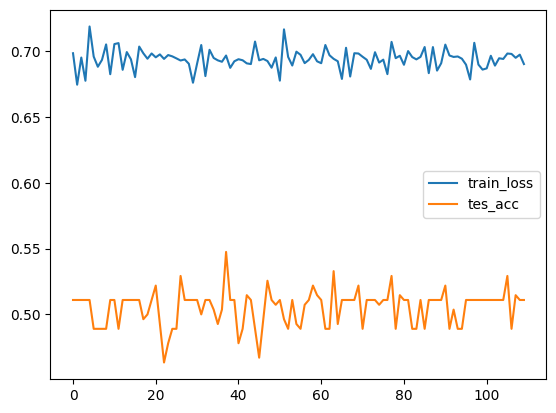

Finished Training


In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(torch_model.parameters(), lr=0.005, momentum=0.9)

train_loss = []
test_acc = []

for epoch in range(10+1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # outputs = model(inputs.reshape([inputs.shape[0], 2, 14]))
        outputs = torch_model(inputs.reshape([inputs.shape[0], 2, 14]))
#         print(outputs.shape, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        step = len(train_dataloader) // 10
        if i % step == step - 1: 
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / step:.3f} ', end='')
            train_loss.append(running_loss / step)
            running_loss = 0.0

            with torch.no_grad():
                predicred_true = 0
                for i, data in enumerate(test_dataloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    outputs = torch_model(inputs.reshape([inputs.shape[0], 2, 14]))
                    predicred_true += int(sum(torch.argmax(outputs, dim=1) == labels.flatten()))

                print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}", end="\r")
                test_acc.append(predicred_true/ len(test_dataloader.dataset))

plt.plot(train_loss, label="train_loss")
plt.plot(test_acc, label="tes_acc")
plt.legend()
plt.show()

print('Finished Training')

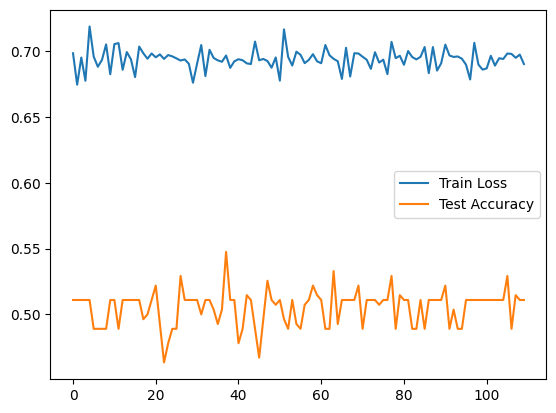

Finished Training


In [23]:
plt.plot(train_loss, label="Train Loss")
plt.plot(test_acc, label="Test Accuracy")
plt.legend()
plt.show()

print('Finished Training')

In [24]:
class TorchModel:
    def __init__(self, model):
        self.model = model

    def fit(self, x_data, y_data):
        return self

    def predict(self, data):
        y_preds = None
        with torch.inference_mode(): 
            y_preds = self.model(torch.tensor(np.array(data).astype(np.float32).reshape([data.shape[0], 2, 14]), dtype=torch.float))
            y_preds = np.argmax(np.array(y_preds), axis=1)
        return pd.DataFrame(y_preds)
    
    def score(self, x_data, y_data):
        if len(y_data) != len(x_data):
            raise Exception("Different data length")
        return sum(np.array(self.predict(x_data)).flatten() == np.array(y_data).flatten()) / len(y_data)

C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


Model earned 89505.50$ out of 353777.63$ starting from 100000$ 
Train accuracy 0.53 
Test accuracy  0.50


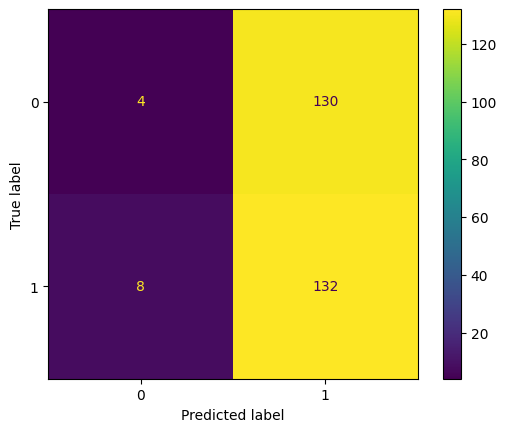

In [25]:
model = TorchModel(torch_model)
y_train_pred_bin = model.predict(X_train)
y_test_pred_bin = model.predict(X_test)

df = rsi_pipe.get_test_price(y_test_pred_bin)  # ! Prediction_ExpProf will not be corret as we 
                                               # ! proposed bin not price

start_capital = 100000
tt = market.BinTraderTest(start_capital, y_test_pred_bin, df["Price_True"])
bt = market.BinTraderTest(start_capital, y_test, df["Price_True"])
traded_capital = tt.trade()
maximal_caital = bt.trade()
print(f"Model earned {(traded_capital):.2f}$ out of {maximal_caital:.2f}$ starting from {start_capital}$ ")

print(f"Train accuracy {model.score(X_train, y_train):.2f} \nTest accuracy  {model.score(X_test, y_test):.2f}")

_ = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_bin)

## Corruption research

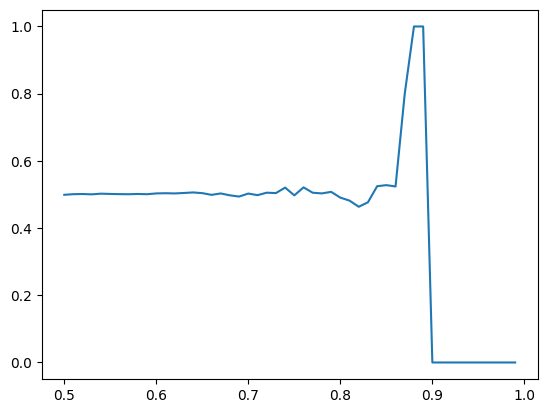

In [39]:
thresholds = [i / 100 for i in range(50, 100)]
window_size = 15

corruptions = []

for threshold in thresholds:
    eps = 0.0001
    y_train_close = y_train.reset_index(drop=True)

    X_train_close = X_train.drop(columns=[f"RSI_{i}" for i in range(window_size-1)]).reset_index(drop=True)
    X_train_close_tmp = X_train_close.transpose().corr()
    X_train_close_tmp[X_train_close_tmp > threshold] = 1
    X_train_close_tmp[X_train_close_tmp <= threshold] = 0

    X_np = X_train_close_tmp.to_numpy()
    y_np = y_train_close.to_numpy().squeeze()

    false_correlated = sum(map(lambda x: int(y_np[x[0]] != y_np[x[1]]), zip(*np.where(X_np > threshold))))
    corruptions.append(( false_correlated / (np.count_nonzero(X_np) - len(y_np) + eps))) 
    print(f"Corruption: {( false_correlated / (np.count_nonzero(X_np) - len(y_np) + eps)):.2f}, thr: {threshold}", end='\r')

plt.plot(thresholds, corruptions)

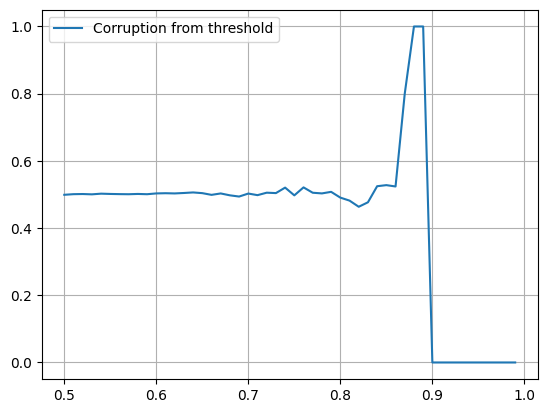

In [41]:
plt.plot(thresholds, corruptions, label="Corruption from threshold")
plt.legend()
plt.grid()

## Data improve

In [1]:
import sys
sys.path.append('..')

import os

from spp import process
from spp import market
import numpy as np
import pandas as pd
import math
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

In [5]:
ticker = "CMCSA"#, "AAPL", "MSFT", "AMZN", "GOOGL"]
# CNN model won't be re-learned foreach case separately, so,
# it should know the year test data
# For "5y" test_coef is 0.22
window_size = 15

def_pipe = process.HistBinPipeline(ticker, period="5y", test_coef=0.22, window_size=window_size)
X_train, y_train, X_valid, y_valid, X_test, y_test = def_pipe.get_data()

[*********************100%***********************]  1 of 1 completed


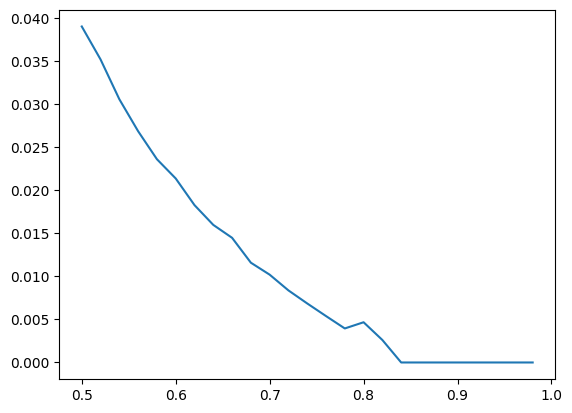

In [13]:
thresholds = [i / 100 for i in range(50, 100, 2)]

corruptions = []

def threshold_corr(dataset, name_prefix, threshold, window_size):
    X_1 = dataset[[f"{name_prefix}_{i}" for i in range(window_size-1)]].reset_index(drop=True)
    X_1 = X_1.transpose().corr()
    X_1[X_1 > threshold] = 1
    X_1[X_1 <= threshold] = 0
    return X_1

y_train_close = y_train.reset_index(drop=True)
y_np = y_train_close.to_numpy().squeeze()

for threshold in thresholds:
    eps = 0.0001
    
    X_open = threshold_corr(X_train, "Open_Rel", threshold, window_size)
    X_lnclose = threshold_corr(X_train, "Close_LnProf", threshold, window_size)
    X_high = threshold_corr(X_train, "High_Rel", threshold, window_size)
    X_low = threshold_corr(X_train, "Low_Rel", threshold, window_size)
    X_rsi = threshold_corr(X_train, "RSI", threshold, window_size)
    parts = 3. - 0.5

    X_np = (X_open + X_lnclose + X_high + X_low).to_numpy()

    false_correlated = sum(map(lambda x: int(y_np[x[0]] != y_np[x[1]]), zip(*np.where(X_np > parts))))
    
    corruptions.append( false_correlated / (np.count_nonzero(X_np) - len(y_np) + eps) ) 
    print(f"Corruption: {( false_correlated / (np.count_nonzero(X_np) - len(y_np) + eps)):.2f}, thr: {threshold}", end="\r")

   
plt.plot(thresholds, corruptions)

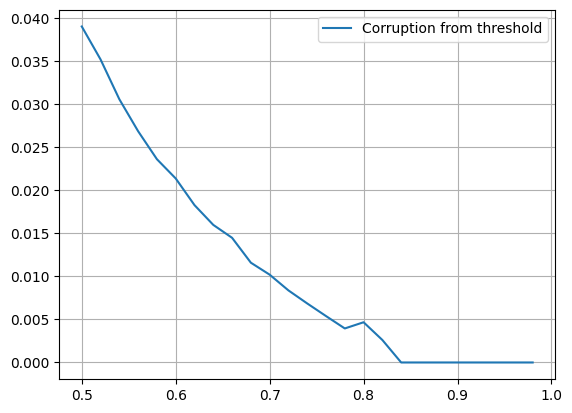

In [14]:
plt.plot(thresholds, corruptions, label="Corruption from threshold")
plt.legend()
plt.grid()

[5,     2] loss: 0.040 | test acc: 0.562 | train acc 1.000

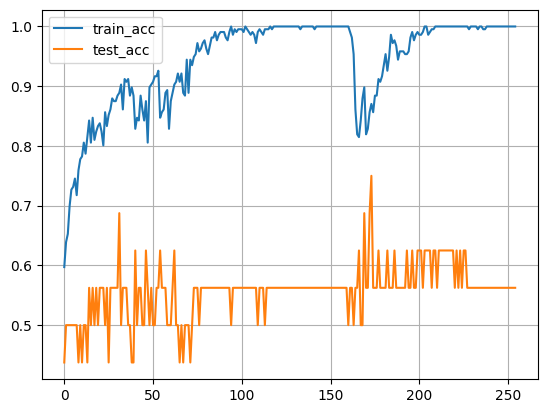

Finished Training


In [451]:

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # outputs = model(inputs.reshape([inputs.shape[0], 2, 14]))
        outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, 14]))
#         print(outputs.shape, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        step = len(train_dataloader)
        if i % step == step - 1: 
            
            with torch.no_grad():
                predicred_true = 0
                for i, data in enumerate(train_dataloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, 14]))
                    predicred_true += int(sum(torch.argmax(outputs, dim=1) == labels.flatten()))

#                 print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}", end="")
                train_loss.append(predicred_true/ len(train_dataloader.dataset))
#             train_loss.append(running_loss / step)

            with torch.no_grad():
                predicred_true = 0
                for i, data in enumerate(test_dataloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, 14]))
#                     print("Output", outputs)
#                     print("Output", torch.argmax(outputs, dim=1))
#                     print("labels", labels)
                    predicred_true += int(sum(torch.argmax(outputs, dim=1) == labels.flatten()))

#                 print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}", end="")
                test_acc.append(predicred_true/ len(test_dataloader.dataset))
            print(f'\r[{epoch + 1}, {i + 1:5d}] loss: {running_loss / step:.3f} | test acc: {predicred_true/ len(test_dataloader.dataset):.3f} | train acc {train_loss[-1]:.3f}', end='', flush=True)
            running_loss = 0.0
            
            if predicred_true / len(test_dataloader.dataset) > best_acc:
                best_model = copy.deepcopy(torch_model)
                best_acc = predicred_true/ len(test_dataloader.dataset)
                
plt.plot(train_loss, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.legend()
plt.grid(True)
plt.show()

print('Finished Training')

### New approach

In [213]:
tickers = ["CMCSA"]#, "AAPL", "MSFT", "AMZN", "GOOGL"]
# CNN model won't be re-learned foreach case separately, so,
# it should know the year test data
# For "5y" test_coef is 0.22
window_size = 15

def_pipe = process.HistBinPipeline(tickers, end="2022-06-01", start="2020-06-01", test_coef=1/2/6, window_size=window_size)
X_train, y_train, X_valid, y_valid, X_test, y_test = def_pipe.get_data()

In [214]:
X_train = X_train[:len(X_train) // 8 * 8]
X_valid = X_valid[:len(X_valid) // 8 * 8]
X_test = X_test[:len(X_test) // 8 * 8]

y_train = y_train[:len(y_train) // 8 * 8]
y_valid = y_valid[:len(y_valid) // 8 * 8]
y_test = y_test[:len(y_test) // 8 * 8]

len(X_train), len(X_valid), len(X_test)

(408, 40, 40)

In [215]:
X_train.info()

In [216]:
X_train[[f"RSI_{i}" for i in range(14)]] /= 100
X_valid[[f"RSI_{i}" for i in range(14)]] /= 100
X_test[[f"RSI_{i}" for i in range(14)]] /= 100
X_train[[f"RSI_{i}" for i in range(14)]]

,RSI_0,RSI_1,RSI_2,RSI_3,RSI_4,RSI_5,RSI_6,RSI_7,RSI_8,RSI_9,RSI_10,RSI_11,RSI_12,RSI_13
0,1.000000,1.000000,1.000000,0.990103,0.994658,0.996739,0.714455,0.572298,0.363985,0.387867,0.428578,0.422042,0.380629,0.406656
1,1.000000,1.000000,0.990103,0.994658,0.996739,0.714455,0.572298,0.363985,0.387867,0.428578,0.422042,0.380629,0.406656,0.380074
2,1.000000,0.990103,0.994658,0.996739,0.714455,0.572298,0.363985,0.387867,0.428578,0.422042,0.380629,0.406656,0.380074,0.334381
3,0.990103,0.994658,0.996739,0.714455,0.572298,0.363985,0.387867,0.428578,0.422042,0.380629,0.406656,0.380074,0.334381,0.420740
4,0.994658,0.996739,0.714455,0.572298,0.363985,0.387867,0.428578,0.422042,0.380629,0.406656,0.380074,0.334381,0.420740,0.376447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,0.492672,0.494883,0.516807,0.481134,0.517761,0.561713,0.545311,0.568859,0.596160,0.474753,0.486025,0.477925,0.442543,0.471765
404,0.494883,0.516807,0.481134,0.517761,0.561713,0.545311,0.568859,0.596160,0.474753,0.486025,0.477925,0.442543,0.471765,0.442384
405,0.516807,0.481134,0.517761,0.561713,0.545311,0.568859,0.596160,0.474753,0.486025,0.477925,0.442543,0.471765,0.442384,0.367769
406,0.481134,0.517761,0.561713,0.545311,0.568859,0.596160,0.474753,0.486025,0.477925,0.442543,0.471765,0.442384,0.367769,0.344498


## Convolutional NN: Second try

In [217]:
CHANNELS = 5

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class CustomStockDataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X).astype(np.float32)
        self.y = np.array(y).astype(np.longlong).flatten()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

training_data = CustomStockDataset(X_train, y_train)
valid_data = CustomStockDataset(X_valid, y_valid)
test_data = CustomStockDataset(X_test, y_test)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=8, shuffle=False, drop_last=True)
valid_dataloader = DataLoader(valid_data, batch_size=8, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=False, drop_last=True)

In [218]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class forecasting_model(nn.Module):
    
    def __init__(self, input_features, output_features, print_shapes = False):
        super().__init__()
        self.conv    = nn.Conv1d(in_channels = input_features, out_channels = 128, kernel_size = 3, padding = 1)
        self.pool1   = nn.AdaptiveAvgPool1d(1)
        self.pool2   = nn.AdaptiveMaxPool1d(1)
        self.flatten = nn.Flatten()
        self.bn      = nn.BatchNorm1d(num_features = 2 * 128)
        self.relu    = nn.ReLU()
        self.fc      = nn.Linear(in_features = 2 * 128, out_features = output_features)
        self.print_shapes = print_shapes
        
    def forward(self, x):
        
        if self.print_shapes: print(f"{'Input Batch Shape':<25} {x.shape}")
        
        conv_op = self.conv(x)
        if self.print_shapes: print(f"{'Conv Output Shape':<25} {conv_op.shape}")
        
        avg_pool = self.pool1(conv_op)
        max_pool = self.pool2(conv_op)
        final_pool = torch.cat([avg_pool, max_pool], dim = -1)
        flattened_op = self.flatten(final_pool)
        if self.print_shapes: print(f"{'Pooled Output Shape':<25} {flattened_op.shape}")
        
        final_op = self.fc(self.bn(self.relu(flattened_op)))
        if self.print_shapes: print(f"{'Output Shape':<25} {final_op.shape}")
            
        return final_op
    
torch_model = forecasting_model(CHANNELS, 2, False)
summary(torch_model, (CHANNELS, 14))

In [219]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(torch_model.parameters(), lr = 3e-3, momentum=0.9)
train_loss = []
valid_loss = []
test_acc = []

save_history = []

best_model = None
best_acc = 0

In [220]:
len(train_dataloader), len(valid_dataloader), len(test_dataloader)

(51, 5, 5)

In [221]:
import copy

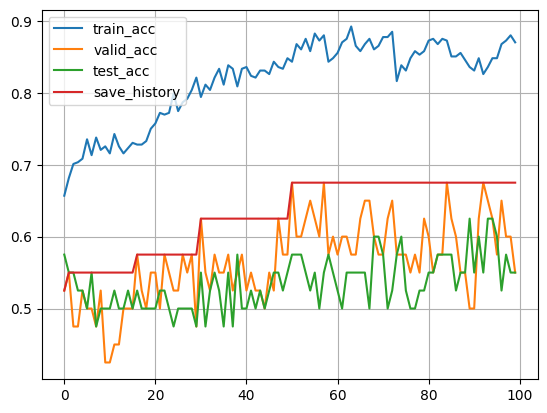

In [222]:

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # outputs = model(inputs.reshape([inputs.shape[0], 2, 14]))
        outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, 14]))
#         print(outputs.shape, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        step = len(train_dataloader)
        if i % step == step - 1: 
            
            with torch.no_grad():
                predicred_true = 0
                for i, data in enumerate(train_dataloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, 14]))
                    predicred_true += int(sum(torch.argmax(outputs, dim=1) == labels.flatten()))

#                 print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}", end="")
                train_loss.append(predicred_true/ len(train_dataloader.dataset))
#             train_loss.append(running_loss / step)

            with torch.no_grad():
                predicred_true = 0
                for i, data in enumerate(test_dataloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, 14]))
#                     print("Output", outputs)
#                     print("Output", torch.argmax(outputs, dim=1))
#                     print("labels", labels)
                    predicred_true += int(sum(torch.argmax(outputs, dim=1) == labels.flatten()))

#                 print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}", end="")
                test_acc.append(predicred_true/ len(test_dataloader.dataset))
    
            predicred_true = 0
            with torch.no_grad():
                for i, data in enumerate(valid_dataloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, 14]))
#                     print("Output", outputs)
#                     print("Output", torch.argmax(outputs, dim=1))
#                     print("labels", labels)
                    predicred_true += int(sum(torch.argmax(outputs, dim=1) == labels.flatten()))

#                 print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}", end="")
                valid_loss.append(predicred_true/ len(test_dataloader.dataset))

            print(f'\r[{epoch + 1}, {i + 1:5d}] loss: {running_loss / step:.3f} | test acc: {test_acc[-1]:.3f} | valid acc: {valid_loss[-1]:.3f} | train acc {train_loss[-1]:.3f}', end='', flush=True)
            running_loss = 0.0
            
            if predicred_true / len(test_dataloader.dataset) > best_acc:
                best_model = copy.deepcopy(torch_model)
                best_acc = predicred_true/ len(test_dataloader.dataset)
                
            save_history.append(best_acc)
                
plt.plot(train_loss, label="train_acc")
plt.plot(valid_loss, label="valid_acc")
plt.plot(test_acc, label="test_acc")
plt.plot(save_history, label="save_history")
plt.legend()
plt.grid(True)
plt.show()

print('Finished Training')

In [223]:
len(test_dataloader.dataset), len(test_dataloader)

(40, 5)

In [224]:
class TorchModel:
    def __init__(self, model):
        self.model = model
        self.batch_size = 8

    def fit(self, x_data, y_data):
        return self

    def predict_dl(self, dataloader):
        y_preds = []
        with torch.no_grad():
            predicred_true = 0
            for i, data in enumerate(dataloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                outputs = self.model(inputs.reshape([inputs.shape[0], CHANNELS, 14]))
                y_preds += torch.argmax(outputs, dim=1).tolist()

#                 print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}", end="")
#             train_loss.append(running_loss / step)

        return pd.DataFrame(y_preds)

    def predict(self, data_ext):
        add_count = self.batch_size - len(data_ext) % self.batch_size
        ori_len = len(data_ext)
        data = copy.deepcopy(data_ext)
        for i in range(add_count):
            data = data.append(data.iloc[0], ignore_index=True)
        
        dataset = CustomStockDataset(data, [-1 for i in range(len(data))])
        dataloader = DataLoader(dataset, batch_size=8, shuffle=False, drop_last=False)
        return self.predict_dl(dataloader)[:ori_len]
    
    def score_dl(self, x_dataloader, y_data):
        if len(y_data) != len(x_dataloader.dataset):
            raise Exception("Different data length")
#         print(np.array(self.predict(x_dataloader)).flatten() == np.array(y_data).flatten())
        return sum(np.array(self.predict_dl(x_dataloader)).flatten() == np.array(y_data).flatten()) / len(y_data)

    def score(self, x_data, y_data):
        if len(y_data) != len(x_data):
            raise Exception("Different data length")
#         print(np.array(self.predict(x_dataloader)).flatten() == np.array(y_data).flatten())
        return sum(np.array(self.predict(x_data)).flatten() == np.array(y_data).flatten()) / len(y_data)

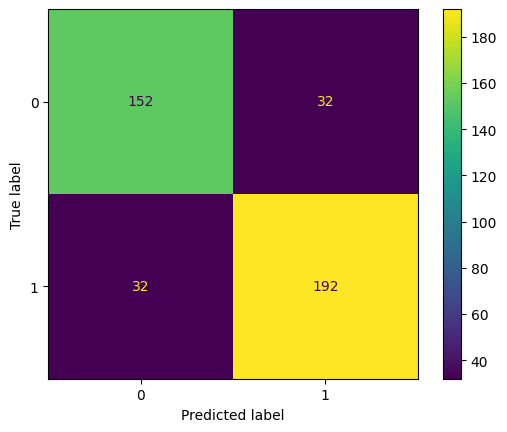

In [225]:
model = TorchModel(best_model)
y_train_pred_bin = model.predict_dl(train_dataloader)
y_valid_pred_bin = model.predict_dl(valid_dataloader)
y_test_pred_bin = model.predict_dl(test_dataloader)

# df = def_pipe.get_test_price(y_test_pred_bin)  # ! Prediction_ExpProf will not be corret as we 
#                                                # ! proposed bin not price

# start_capital = 100000
# tt = market.BinTraderTest(start_capital, y_test_pred_bin, df["Price_True"])
# bt = market.BinTraderTest(start_capital, y_test, df["Price_True"])
# traded_capital = tt.trade()
# maximal_caital = bt.trade()
# print(f"Model earned {(traded_capital):.2f}$ out of {maximal_caital:.2f}$ starting from {start_capital}$ ")

print(f"Train accuracy {model.score_dl(train_dataloader, y_train):.2f}")
print(f"Valid accuracy {model.score_dl(valid_dataloader, y_valid):.2f}")
print(f"Test accuracy  {model.score_dl(test_dataloader, y_test):.2f}")

_ = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_bin)

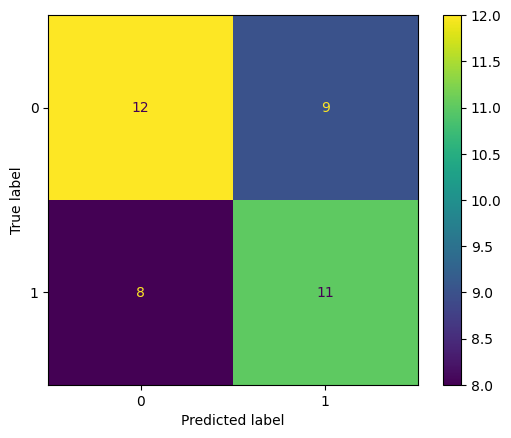

In [226]:
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_bin)

In [227]:
byt = market.BinYearTest(tickers, process.HistBinPipeline, end_date=None, window_size=15)

In [228]:
orig_stdout = sys.stdout
orig_stderr = sys.stderr
f = open(os.devnull, 'w')
sys.stdout = f
sys.stderr = f
year_test_df = byt.trade(model)
sys.stdout = orig_stdout
sys.stderr = orig_stderr

In [229]:
year_test_df

,Month,TrainAcc,TestAcc,Income,Potential
0,Jun_2022,0.621849,0.705882,0.985177,-0.224187
1,Jul_2022,0.554622,0.588235,1.014576,0.167600
2,Aug_2022,0.607595,0.388889,0.986844,-0.216034
3,Sep_2022,0.579832,0.631579,0.941759,-0.493834
4,Oct_2022,0.546218,0.500000,1.040197,0.625789
5,Nov_2022,0.561181,0.352941,1.003814,0.036806
6,Dec_2022,0.550420,0.611111,1.006303,0.078177
7,Jan_2023,0.571429,0.466667,1.031548,0.442787
8,Feb_2023,0.662447,0.687500,1.016432,0.411261
9,Mar_2023,0.531646,0.578947,0.999928,-0.001155


In [230]:
from functools import reduce
items = list(year_test_df["Income"])
reduced_income = reduce(lambda a,b: a*b, items)
print("Year capital multiplier", reduced_income)
reduced_income

1.1608905403622183

## Regression data